Planned generation allocation to 9 zones for PJM

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import us
import numpy as np
import pandas as pd
import numpy as np
from pypower.api import runopf, ppoption
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [4]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 16
})

In [1]:
import os
from pathlib import Path

BASE_DIR = Path.cwd()  

# Generate Planned Scenario (2030)

In [5]:


# -------------------------------
# 0. Load generation data
# -------------------------------
file_path = BASE_DIR / "data/inputs/Base_Case/eia8602024/3_1_Generator_Y2024.xlsx"

gen_operable = pd.read_excel(file_path, sheet_name="Operable", header=1)
gen_proposed = pd.read_excel(file_path, sheet_name="Proposed", header=1)

# Standardize column names
def clean_columns(df):
    df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")
    df.columns = df.columns.str.upper()
    return df

gen_operable = clean_columns(gen_operable)
gen_proposed = clean_columns(gen_proposed)

# -------------------------------
# 1. Filter PJM states
# -------------------------------
pjm_states = ['DE', 'IL', 'IN', 'KY', 'MD', 'MI', 'NJ', 'NC', 'OH', 'PA', 'TN', 'VA', 'WV', 'DC']

gen_operable = gen_operable[gen_operable['STATE'].str.upper().isin(pjm_states)].copy()
gen_proposed = gen_proposed[gen_proposed['STATE'].str.upper().isin(pjm_states)].copy()

# -------------------------------
# 2. Filter operable plants retiring before 2030
# -------------------------------
gen_operable['PLANNED_RETIREMENT_YEAR'] = pd.to_numeric(gen_operable['PLANNED_RETIREMENT_YEAR'], errors='coerce')
gen_operable = gen_operable[
    (gen_operable['PLANNED_RETIREMENT_YEAR'].isna()) |
    (gen_operable['PLANNED_RETIREMENT_YEAR'] >= 2030)
].copy()

# -------------------------------
# 3. Assign lat/lon to operable plants
# -------------------------------

latlon_df = pd.read_excel(
    BASE_DIR / "data/inputs/Base_Case/eia8602024/2___Plant_Y2024.xlsx",
    header=1
)
latlon_df = clean_columns(latlon_df)

# Merge lat/lon on unique plant identifier
gen_operable = gen_operable.merge(latlon_df[['PLANT_NAME', 'LATITUDE', 'LONGITUDE']], 
                                  left_on='PLANT_NAME', right_on='PLANT_NAME', how='left')

# Convert lat/lon to numeric, drop missing values
gen_operable['LATITUDE'] = pd.to_numeric(gen_operable['LATITUDE'], errors='coerce')
gen_operable['LONGITUDE'] = pd.to_numeric(gen_operable['LONGITUDE'], errors='coerce')
gen_operable = gen_operable.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert to GeoDataFrame
operable_gdf = gpd.GeoDataFrame(
    gen_operable, 
    geometry=gpd.points_from_xy(gen_operable['LONGITUDE'], gen_operable['LATITUDE']),
    crs="EPSG:4326"
)

# -------------------------------
# 4. Load shapefiles
# -------------------------------
zones = gpd.read_file(BASE_DIR / 'data/inputs/ipm_v6_regions/IPM_Regions_201770405.shp').to_crs("EPSG:4326")
ZONE_COL = "IPM_Region"

counties = gpd.read_file(BASE_DIR / 'data/inputs/tl_2025_us_county/tl_2025_us_county.shp').to_crs("EPSG:4326")
counties['STATEFP'] = counties['STATEFP'].astype(str).str.zfill(2)
counties['STATE_NAME'] = counties['STATEFP'].apply(lambda f: us.states.lookup(f, field='fips').abbr if us.states.lookup(f, field='fips') else None)
counties['COUNTY_NAME'] = counties['NAME'].str.upper().str.strip()
counties['COUNTY_NAME_CLEAN'] = counties['COUNTY_NAME']
counties['STATE_NAME_CLEAN'] = counties['STATE_NAME']

# -------------------------------
# 5. Assign zones
# -------------------------------
# 5a. Operable plants by lat/lon
operable_gdf = gpd.sjoin(operable_gdf, zones[[ZONE_COL, 'geometry']], how='left', predicate='intersects')

# 5b. Proposed plants by county
gen_proposed['STATE_CLEAN'] = gen_proposed['STATE'].str.upper().str.strip()
gen_proposed['COUNTY_CLEAN'] = gen_proposed['COUNTY'].str.upper().str.strip()

proposed_gdf = gen_proposed.merge(
    counties[['STATE_NAME_CLEAN', 'COUNTY_NAME_CLEAN', 'geometry']],
    left_on=['STATE_CLEAN','COUNTY_CLEAN'],
    right_on=['STATE_NAME_CLEAN','COUNTY_NAME_CLEAN'],
    how='left'
)

proposed_gdf = gpd.GeoDataFrame(proposed_gdf, geometry='geometry', crs="EPSG:4326")
proposed_gdf = gpd.sjoin(proposed_gdf, zones[[ZONE_COL, 'geometry']], how='left', predicate='intersects')

# -------------------------------
# 6. Fallback: assign nearest zone for unassigned plants
# -------------------------------
def assign_nearest_zone(gdf, zone_gdf, zone_col=ZONE_COL):
    # Create spatial index
    zone_sindex = zone_gdf.sindex
    nearest_zones = []

    for idx, row in gdf.iterrows():
        # Skip if already assigned
        if pd.notna(row[zone_col]):
            nearest_zones.append(row[zone_col])
            continue

        pt = row.geometry
        if pt is None or pt.is_empty:
            nearest_zones.append(None)
            continue

        # Use shapely geometry itself for nearest
        nearest_idx = list(zone_sindex.nearest(pt, return_all=False))[0]
        nearest_zones.append(zone_gdf.iloc[nearest_idx][zone_col])

    gdf[zone_col] = nearest_zones
    return gdf


operable_gdf = assign_nearest_zone(operable_gdf, zones)
proposed_gdf = assign_nearest_zone(proposed_gdf, zones)

# Count how many proposed plants are unassigned
num_unassigned = proposed_gdf[proposed_gdf[ZONE_COL].isna()].shape[0]
print(f"Unassigned proposed plants before assignment: {num_unassigned}")

# Assign all unassigned proposed plants to PJM_SMAC
proposed_gdf.loc[proposed_gdf[ZONE_COL].isna(), ZONE_COL] = "PJM_SMAC"

# Confirm assignment
num_unassigned_after = proposed_gdf[proposed_gdf[ZONE_COL].isna()].shape[0]
print(f"Unassigned proposed plants after assignment: {num_unassigned_after}")

# -------------------------------
# 7. Check results
# -------------------------------
print("Operable plants without zone:", operable_gdf[operable_gdf[ZONE_COL].isna()].shape[0])
print("Proposed plants without zone:", proposed_gdf[proposed_gdf[ZONE_COL].isna()].shape[0])


Unassigned proposed plants before assignment: 13
Unassigned proposed plants after assignment: 0
Operable plants without zone: 0
Proposed plants without zone: 0


In [6]:

all_plants = pd.concat([operable_gdf, proposed_gdf], ignore_index=True)

# -------------------------------
# 6. Prepare MATPOWER CSV
# -------------------------------
all_plants['BUS'] = 0
all_plants['PMIN'] = 0
all_plants['COST'] = 0

print(all_plants.head)

<bound method NDFrame.head of      UTILITY_ID                      UTILITY_NAME  PLANT_CODE  \
0          5580     East Kentucky Power Coop, Inc        54.0   
1          5580     East Kentucky Power Coop, Inc        54.0   
2          5580     East Kentucky Power Coop, Inc        54.0   
3          5580     East Kentucky Power Coop, Inc        54.0   
4          5580     East Kentucky Power Coop, Inc        54.0   
...         ...                               ...         ...   
7495      61194                  Generate Capital     69066.0   
7496      61194                  Generate Capital     69066.0   
7497      61194                  Generate Capital     69066.0   
7498      61194                  Generate Capital     69070.0   
7499      61785  EDP Renewables North America LLC     69079.0   

                   PLANT_NAME STATE      COUNTY GENERATOR_ID  \
0                   J K Smith    KY       Clark          GT1   
1                   J K Smith    KY       Clark         GT10 

In [8]:




# Clean fuel type column
all_plants.rename(columns={'ENERGY_SOURCE_1':'FUEL_TYPE'}, inplace=True)
all_plants['FUEL_TYPE'] = all_plants['FUEL_TYPE'].str.upper()

matpower_df = all_plants[['PLANT_NAME', 'IPM_Region', 'FUEL_TYPE', 'BUS', 'NAMEPLATE_CAPACITY_MW', 'PMIN', 'COST']]
matpower_df.rename(columns={'IPM_Region':'ZONE'}, inplace=True)
matpower_df.rename(columns={'NAMEPLATE_CAPACITY_MW':'PMAX'}, inplace=True)
# Save
# matpower_df.to_csv("/Users/fbasa/Library/CloudStorage/OneDrive-JohnsHopkins/Energy Systems/Project/data/inputs/Planned_Case/generation_PJM_2030.csv", index=False)
matpower_df.to_csv(BASE_DIR / 'data/inputs/Planned_Case/generation_PJM_2030.csv', index=False)
print("PyPOWER CSV ready. Total plants:", len(matpower_df))


PyPOWER CSV ready. Total plants: 7500


/var/folders/b0/mmm07nss4jzc_ktswk1mkzm00000gn/T/ipykernel_8670/2295630624.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matpower_df.rename(columns={'IPM_Region':'ZONE'}, inplace=True)
/var/folders/b0/mmm07nss4jzc_ktswk1mkzm00000gn/T/ipykernel_8670/2295630624.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matpower_df.rename(columns={'NAMEPLATE_CAPACITY_MW':'PMAX'}, inplace=True)


In [9]:
print(matpower_df['PMAX'].apply(type).value_counts())
print(matpower_df['COST'].apply(type).value_counts())

PMAX
<class 'float'>    7500
Name: count, dtype: int64
COST
<class 'int'>    7500
Name: count, dtype: int64


In [12]:
# ============================================================
# 3. Map EIA fuel codes to Fuels_data.csv names
# ============================================================

matpower_df = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/generation_PJM_2030.csv')
fuel_mapping = {
    "ANT": "Bituminous",
    "BIT": "Bituminous",
    "SUB": "Subbituminous",
    "LIG": "Subbituminous",
    "WC": "Waste Coal",
    "RC": "Bituminous",

    "DFO": "Distillate Fuel Oil",
    "RFO": "Residual Fuel Oil",
    "PC": "Petroleum Coke",
    "JF": "Residual Fuel Oil",
    "KER": "Residual Fuel Oil",
    "WO": "Fossil Waste",

    "NG": "Natural Gas",
    "BFG": "Fossil Waste",
    "OG": "Natural Gas",
    "PG": "Natural Gas",
    "SG": "Fossil Waste",
    "SGC": "Fossil Waste",

    "AB": "Biomass",
    "MSW": "MSW",
    "OBS": "Biomass",
    "WDS": "Biomass",
    "SLW": "Biomass",
    "BLQ": "Biomass",
    "OBL": "Biomass",
    "WDL": "Biomass",

    "LFG": "Landfill Gas",
    "OBG": "Biomass",

    "SUN": "None",
    "WND": "None",
    "WAT": "None",
    "GEO": "None",

    "NUC": "Nuclear Fuel",
    "PUR": "None",
    "WH": "None",
    "TDF": "Non-Fossil Waste",
    "MWH": "None",
    "OTH": "None"
}

matpower_df['ZONE'] = matpower_df['ZONE'].astype(str)
matpower_df['FUEL_TYPE'] = matpower_df['FUEL_TYPE'].astype(str)

grouped = matpower_df.groupby(['ZONE', 'FUEL_TYPE'], as_index=False).agg({
    'PMAX': 'sum',
    'COST': 'mean'
})
grouped['FUEL_COST_NAME'] = grouped['FUEL_TYPE'].map(fuel_mapping)

# ============================================================
# 4. Load fuel costs table
# ============================================================
fuel_costs = pd.read_csv( BASE_DIR / 'data/inputs/Planned_Case/Fuels_data.csv')
fuel_costs = fuel_costs.iloc[2]  # use the third row as your constant costs

# ============================================================
# 5. Compute cost per generator
# ============================================================
def compute_cost(fuel_name):
    if pd.isna(fuel_name) or fuel_name == "None":
        return 0
    if fuel_name not in fuel_costs.index:
        print(f"Warning: '{fuel_name}' not in fuel cost table, assigning 0")
        return 0
    return fuel_costs[fuel_name]

grouped['COST'] = grouped['FUEL_COST_NAME'].apply(compute_cost)

# ============================================================
# 6. Group by Zone × Fuel Type
# ============================================================


# ============================================================
# 7. Prepare PYPOWER CSV
# ============================================================
grouped["GEN_ID"] = ["GEN_" + str(i+1) for i in range(len(grouped))]
grouped["PLANT_NAME"] = grouped['FUEL_TYPE'] + "_" + grouped['ZONE']
grouped["FUEL_TYPE"] = grouped['FUEL_TYPE']
grouped["BUS"] = 0   # placeholder, can be updated with actual bus numbers
grouped["PG"] = 0    # initial dispatch
grouped["PMAX"] = grouped['PMAX']
grouped["PMIN"] = 0
grouped["COST"] = grouped['COST']

# ============================================================
# 8. Save CSV
# ============================================================
outfile = BASE_DIR / "data/inputs/Planned_Case/combined_generation.csv"
grouped.to_csv(outfile, index=False)
print(f"PYPOWER generator CSV saved: {outfile}")



PYPOWER generator CSV saved: /Users/fbasa/Library/CloudStorage/OneDrive-JohnsHopkins/Energy Systems/Project/GitHub/data/inputs/Planned_Case/combined_generation.csv


# Modify wind and solar data

In [13]:
# This cell is used to pick and then multiply the wind and solar from the planned case
import pandas as pd
policy_scale_solar = 2.33
accelerated_scale_solar = 6.68 
policy_scale_wind = 5.92
accelerated_scale_wind = 21.78
wind_eta = 0.3
plan_gen = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/combined_generation.csv')
plan_gen.loc[plan_gen['FUEL_TYPE'] == 'WND', 'PMAX'] *= 1 * wind_eta # This multiplies the PMAX of WND rows by a scalar
plan_gen.loc[plan_gen['FUEL_TYPE'] == 'SUN', 'PMAX'] *= 1 # This multiplies the PMAX of SUN rows by a scalar
# Save the modified DataFrame to a new csv file
plan_gen.to_csv(BASE_DIR / 'data/inputs/Planned_Case/combined_generation_modified.csv', index=False)
print("File saved successfully.")

File saved successfully.


# Modify Network Data

In [14]:
# This cell is used to multiply the line capacity from the Network.csv file. 
network_df = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/Network.csv')

# There are multiple ways to modify the network. Pick one. 
# Multiply the 'Line_Max_Flow_MW' column by 10 for all rows
# network_df['Line_Max_Flow_MW'] = network_df['Line_Max_Flow_MW'] * 1
# Or change the 300 rows to 400
network_df.loc[network_df['Line_Max_Flow_MW'] == 300, 'Line_Max_Flow_MW'] = 300 + 750 # SMAC EMAC
network_df.loc[network_df['Line_Max_Flow_MW'] == 1100, 'Line_Max_Flow_MW'] = 1100 + 750 # SMAC AP
network_df.loc[network_df['Line_Max_Flow_MW'] == 780, 'Line_Max_Flow_MW'] = 780 + 750 # SMAC WMAC
network_df.loc[network_df['Line_Max_Flow_MW'] == 1200, 'Line_Max_Flow_MW'] = 1200 + 750 # SMAC DOM

# Save the modified DataFrame to a new csv file
network_df.to_csv(BASE_DIR / 'data/inputs/Planned_Case/Network_modified.csv', index=False)

print(f"Successfully saved modified file")

Successfully saved modified file


In [15]:
# 1. Load your 2025 load data
# load = pd.read_csv("/Users/fbasa/Library/CloudStorage/OneDrive-JohnsHopkins/Energy Systems/Project/data/inputs/Planned_Case/annual_zonal_nspl_2024.csv")  # assumed columns: ['Hour','DAY','DEOK','AECO',...]
load = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/annual_zonal_nspl_2024.csv')

# Inspect columns
print(load.columns)

# 2. Filter only zone names and peak values
# Adjust column names below to match your CSV
load_filtered = load[['zone', 'nspl_mw']].copy()

# 3. Map the zones from your CSV to your 9 PJM zones
# Example: create a dictionary if your CSV zone names differ

zone_mapping = {
    'DAY': 'PJM_West',
    'DEOK': 'PJM_West',
    'AECO': 'PJM_EMAC',
    'METED': 'PJM_WMAC',
    'PSEG': 'PJM_EMAC',
    'DPL': 'PJM_SMAC',
    'JCPL': 'PJM_EMAC',
    'PECO': 'PJM_EMAC',
    'PEPCO': 'PJM_SMAC',
    'RECO': 'PJM_EMAC',
    'ATSI': 'PJM_ATSI',
    'BGE': 'PJM_SMAC',
    'COMED': 'PJM_COMD',
    'DUQ': 'PJM_West',
    'OVEC': 'PJM_West',
    'DOM': 'PJM_Dom',
    'PENELEC': 'PJM_PENE',
    'PPL': 'PJM_WMAC',
    'AEP': 'PJM_West',
    'APS': 'PJM_AP',
    'EKPC': 'PJM_West'
}

load_filtered['PJM_Zone'] = load_filtered['zone'].map(zone_mapping)

# 4. Optional: aggregate if multiple CSV zones map to one PJM zone
load_agg = load_filtered.groupby('PJM_Zone')['nspl_mw'].sum().reset_index()


Index(['year', 'datetime_beginning_utc', 'datetime_beginning_ept',
       'datetime_ending_utc', 'datetime_ending_ept', 'zone', 'nspl_mw'],
      dtype='object')


In [16]:
# Correct: scale only the numeric load column
load_agg['Peak_Load_2030'] = load_agg['nspl_mw'] * 1.095

# Optional: keep only scaled column
load_2030 = load_agg[['PJM_Zone', 'Peak_Load_2030']]



# Optional: reset index for easy CSV export
load_2030 = load_2030.reset_index()


# Save to CSV
print(load_2030)
load_2030.to_csv(BASE_DIR / 'data/inputs/Planned_Case/load.csv', index=False)


   index  PJM_Zone  Peak_Load_2030
0      0    PJM_AP       9786.6720
1      1  PJM_ATSI      13696.5885
2      2  PJM_COMD      23607.7620
3      3   PJM_Dom      25313.9910
4      4  PJM_EMAC      30612.2580
5      5  PJM_PENE       3233.7540
6      6  PJM_SMAC      18742.1295
7      7  PJM_WMAC      11526.5175
8      8  PJM_West      40835.7255


# Pick data for ppc

In [17]:


# -----------------------------
# File paths
# -----------------------------
loads_file = BASE_DIR /  "data/inputs/Planned_Case/load.csv"
network_file =  BASE_DIR / 'data/inputs/Planned_Case/Network.csv'
gens_file = BASE_DIR /  'data/inputs/Planned_Case/combined_generation.csv'
gens_file_modified =  BASE_DIR / 'data/inputs/Planned_Case/combined_generation_modified.csv'
network_file_modified =  BASE_DIR / 'data/inputs/Planned_Case/Network_modified.csv'
# -----------------------------
# Load data
# -----------------------------
#loads = dict(zip(load_agg['PJM_Zone'], load_agg['Peak_Load_2030']))
loads = pd.read_csv(loads_file)
load_dict = dict(zip(loads["PJM_Zone"], loads["Peak_Load_2030"]))
# network = pd.read_csv(network_file)
# gens = pd.read_csv(gens_file)
gens = pd.read_csv(gens_file_modified)
network = pd.read_csv(network_file_modified)


# -----------------------------
# Explicit 9 zones
# -----------------------------
zones = ['PJM_AP', 'PJM_ATSI', 'PJM_COMD', 'PJM_Dom', 
         'PJM_EMAC', 'PJM_PENE', 'PJM_SMAC', 'PJM_WMAC', 'PJM_West']
bus_map = {zone: i+1 for i, zone in enumerate(zones)}  # bus numbers 1-9

# -----------------------------
# Peak load row
# -----------------------------

gen_per_bus = gens.groupby('ZONE')['PMAX'].sum()
print(gen_per_bus)
slack_bus_zone = gen_per_bus.idxmax()
# -----------------------------
# Create bus data
# -----------------------------
bus_data = []
for i, zone in enumerate(zones):
    bus_num = i+1 
    Pd = float(load_dict.get(zone,0))
    Qd = 0
    bus_type = 3 if zone == slack_bus_zone else 1
    bus_data.append([bus_num, bus_type, Pd, Qd, 0, 0, 1, 1.0, 0, 0, 0, 0])
bus_data = np.array(bus_data)

# -----------------------------
# Generator data
# -----------------------------
gens['ZONE'] = gens['ZONE'].str.strip()
gens = gens[gens['ZONE'].isin(zones)]  # only valid zones

gen_data = []
for _, row in gens.iterrows():
    bus_num = int(bus_map[row['ZONE']])
    PG = float(row['PG'])
    QG = 0.0
    QMAX = float(row['QMAX']) if 'QMAX' in row else 0.0
    QMIN = float(row['QMIN']) if 'QMIN' in row else 0.0
    VG = 1.0
    MBASE = 100.0
    GEN_STATUS = 1
    PMAX = float(row['PMAX'])
    PMIN = float(row['PMIN'])
    PC1 = 0.0
    PC2 = 0.0
    QC1MIN = 0.0
    QC1MAX = 0.0

    gen_data.append([bus_num, PG, QG, QMAX, QMIN, VG, MBASE, GEN_STATUS, PMAX, PMIN, PC1, PC2, QC1MIN, QC1MAX])

gen_data = np.array(gen_data, dtype=float)
print("gen_data shape:", gen_data.shape)  # Should be (n_gen, 14)


# -----------------------------
# Branch data
# -----------------------------
branch_data = []
branch_index = []   # <--- this is where we store MATPOWER branch row indices

for i, row in network.iterrows():
    fbus = bus_map[row['Start_Zone'].strip()]
    tbus = bus_map[row['End_Zone'].strip()]
    r = 0.1  # small impedance
    x = 0.1
    b = 0.0
    rateA = row['Line_Max_Flow_MW']
    branch_data.append([fbus, tbus, r, x, b, rateA, rateA, rateA, 0, 0, 1])
    branch_index.append(i)

branch_data = np.array(branch_data)

network["branch_idx"] = branch_index
network.to_csv(network_file_modified)
# gen_data shape: [n_gen, 13] in your setup
# last column is cost
# -----------------------------
# Generator cost (linear)
# -----------------------------
gencost_data = []
for _, row in gens.iterrows():
    # Assuming linear cost only: cost_per_MWh
    cost = float(row['COST'])
    gencost_data.append([2, 0, 0, 2, cost, 0])



# -----------------------------
# Build PyPower case
# -----------------------------
ppc = {
    'version': '2',
    'baseMVA': 100,
    'bus': bus_data,
    'gen': gen_data,
    'branch': branch_data,
    'gencost':  np.array(gencost_data),   
}

num_gen = ppc['gen'].shape[0]

ZONE
0    ERC_PHDL\nName: IPM_Region, dtype: object       73.60
MIS_AR                                              237.20
MIS_IA                                               10.60
MIS_IL                                            18456.30
MIS_INKY                                          30993.59
MIS_LMI                                           27141.85
MIS_MIDA                                              5.00
MIS_MNWI                                              1.40
MIS_MO                                              166.82
MIS_WUMS                                            721.74
NY_Z_A                                              140.00
NY_Z_B                                              155.00
NY_Z_C&E                                            135.50
NY_Z_G-I                                            950.90
NY_Z_J                                                2.60
PJM_AP                                            17407.47
PJM_ATSI                                          2

In [18]:
print(ppc)

{'version': '2', 'baseMVA': 100, 'bus': array([[1.00000000e+00, 1.00000000e+00, 9.78667200e+03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 1.00000000e+00, 1.36965885e+04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 1.00000000e+00, 2.36077620e+04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.00000000e+00, 1.00000000e+00, 2.53139910e+04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 1.00000000e+00, 3.06122580e+04, 0.00000000e+00,
        0.00000000e+

In [19]:
import numpy as np

bus_numbers = bus_data[:, 0]  # bus_i
Pd_values = bus_data[:, 2]    # Pd

for bus, Pd in zip(bus_numbers, Pd_values):
    if Pd > 0:
        print(f"Bus {int(bus)} has load: {Pd} MW")
    else:
        print(f"Bus {int(bus)} has no load")


Bus 1 has load: 9786.672 MW
Bus 2 has load: 13696.588499999998 MW
Bus 3 has load: 23607.762 MW
Bus 4 has load: 25313.991 MW
Bus 5 has load: 30612.258 MW
Bus 6 has load: 3233.754 MW
Bus 7 has load: 18742.1295 MW
Bus 8 has load: 11526.5175 MW
Bus 9 has load: 40835.7255 MW


In [72]:
gen_buses = gen_data[:, 0]  # bus_i
unique_gen_buses = np.unique(gen_buses)

for bus in bus_numbers:
    if bus in unique_gen_buses:
        print(f"Bus {int(bus)} has generation")
    else:
        print(f"Bus {int(bus)} has no generation")


Bus 1 has generation
Bus 2 has generation
Bus 3 has generation
Bus 4 has generation
Bus 5 has generation
Bus 6 has generation
Bus 7 has generation
Bus 8 has generation
Bus 9 has generation


In [20]:
print(gens.columns)


Index(['ZONE', 'FUEL_TYPE', 'PMAX', 'COST', 'FUEL_COST_NAME', 'GEN_ID',
       'PLANT_NAME', 'BUS', 'PG', 'PMIN'],
      dtype='object')


In [21]:
 # Print generator mapping to buses
for i, row in gens.iterrows():
    bus_num = bus_map.get(row['ZONE'], None)
    if bus_num is None:
        print(f"Generator {row['PLANT_NAME']} has invalid zone: {row['ZONE']}")
    else:
        print(f"Generator {row['PLANT_NAME']} assigned to Bus {bus_num}")


Generator BFG_PJM_AP assigned to Bus 1
Generator BIT_PJM_AP assigned to Bus 1
Generator DFO_PJM_AP assigned to Bus 1
Generator JF_PJM_AP assigned to Bus 1
Generator LFG_PJM_AP assigned to Bus 1
Generator MWH_PJM_AP assigned to Bus 1
Generator NG_PJM_AP assigned to Bus 1
Generator OG_PJM_AP assigned to Bus 1
Generator RC_PJM_AP assigned to Bus 1
Generator SUN_PJM_AP assigned to Bus 1
Generator WAT_PJM_AP assigned to Bus 1
Generator WC_PJM_AP assigned to Bus 1
Generator WND_PJM_AP assigned to Bus 1
Generator BFG_PJM_ATSI assigned to Bus 2
Generator BIT_PJM_ATSI assigned to Bus 2
Generator DFO_PJM_ATSI assigned to Bus 2
Generator LFG_PJM_ATSI assigned to Bus 2
Generator MWH_PJM_ATSI assigned to Bus 2
Generator NG_PJM_ATSI assigned to Bus 2
Generator NUC_PJM_ATSI assigned to Bus 2
Generator OBG_PJM_ATSI assigned to Bus 2
Generator OG_PJM_ATSI assigned to Bus 2
Generator PC_PJM_ATSI assigned to Bus 2
Generator SUN_PJM_ATSI assigned to Bus 2
Generator WAT_PJM_ATSI assigned to Bus 2
Generator

In [22]:
for i, bus in enumerate(bus_data):
    Pd = bus[2]
    print(f"Bus {int(bus[0])} has load Pd={Pd} MW")


Bus 1 has load Pd=9786.672 MW
Bus 2 has load Pd=13696.588499999998 MW
Bus 3 has load Pd=23607.762 MW
Bus 4 has load Pd=25313.991 MW
Bus 5 has load Pd=30612.258 MW
Bus 6 has load Pd=3233.754 MW
Bus 7 has load Pd=18742.1295 MW
Bus 8 has load Pd=11526.5175 MW
Bus 9 has load Pd=40835.7255 MW


In [23]:
import networkx as nx

G = nx.Graph()

# Add buses as nodes
for bus in bus_data[:, 0]:
    G.add_node(int(bus))

# Add branches as edges
for branch in branch_data:
    fbus = int(branch[0])
    tbus = int(branch[1])
    G.add_edge(fbus, tbus)

# Check connected components
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")
for i, comp in enumerate(components):
    print(f"Component {i+1}: {comp}")


Number of connected components: 1
Component 1: {1, 2, 3, 4, 5, 6, 7, 8, 9}


In [24]:
bus_loads = bus_data[:, 2]  # Pd column
total_load = np.sum(bus_loads)
total_gen_max = np.sum(gens['PMAX'])
print("Total system load:", total_load)
print("Total maximum generation:", total_gen_max)


Total system load: 177355.398
Total maximum generation: 243235.66999999998


In [25]:
if 'COST' in gens.columns:
    print("Generator costs exist for all generators.")
else:
    print("Missing generator costs! You need to add gencost for each generator.")


Generator costs exist for all generators.


In [26]:
print(gencost_data)

[[2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 2.14, 0], [2, 0, 0, 2, 21.5, 0], [2, 0, 0, 2, 18.0, 0], [2, 0, 0, 2, 1.5, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 2.55, 0], [2, 0, 0, 2, 2.55, 0], [2, 0, 0, 2, 2.14, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 5.53, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 2.14, 0], [2, 0, 0, 2, 21.5, 0], [2, 0, 0, 2, 1.5, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 2.55, 0], [2, 0, 0, 2, 0.7, 0], [2, 0, 0, 2, 7.39, 0], [2, 0, 0, 2, 2.55, 0], [2, 0, 0, 2, 1.8, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 7.39, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 21.5, 0], [2, 0, 0, 2, 18.0, 0], [2, 0, 0, 2, 1.5, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 2.55, 0], [2, 0, 0, 2, 0.7, 0], [2, 0, 0, 2, 7.39, 0], [2, 0, 0, 2, 2.55, 0], [2, 0, 0, 2, 2.14, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0, 2, 2.14, 0], [2, 0, 0, 2, 7.39, 0], [2, 0, 0, 2, 21.5, 0], [2, 0, 0, 2, 1.5, 0], [2, 0, 0, 2, 0.0, 0], [2, 0, 0,

In [27]:
import networkx as nx

G = nx.Graph()
for fbus, tbus in branch_data[:, :2]:
    G.add_edge(int(fbus), int(tbus))

print("Is the network fully connected?", nx.is_connected(G))


Is the network fully connected? True


In [28]:

# Suppose you want to set a new slack bus at bus number `new_slack_bus_num`
new_slack_bus_num = 5  # for example, the bus index in ppc['bus'] (0-based index)
old_slack_index = np.where(ppc['bus'][:, 1] == 3)[0]

# 1. Change old slack bus type to PV (2) or PQ (1) depending on your system
ppc['bus'][old_slack_index, 1] = 2  # usually PV if generator exists

# 2. Set new slack bus
ppc['bus'][new_slack_bus_num, 1] = 3

print("New slack bus index:", new_slack_bus_num)


New slack bus index: 5


In [29]:
slack_bus_index = np.where(ppc['bus'][:, 1] == 3)[0]  # if type=3 is slack in PYPOWER bus type
print("Slack bus:", slack_bus_index)


Slack bus: [5]


In [30]:
for i, g in enumerate(ppc['gen']):
    if g[1] > g[8] or g[8]==0:
        print(f"Gen {i} on bus {g[0]} has invalid limits: PG={g[1]}, PMAX={g[8]}")


In [31]:
print("Bus connectivity check:")
connected_buses = set(ppc['branch'][:, [0,1]].flatten())
all_buses = set(ppc['bus'][:,0])
print("Disconnected buses:", all_buses - connected_buses)


Bus connectivity check:
Disconnected buses: set()


In [32]:
if np.any(ppc['branch'][:,2:4]==0):
    print("Warning: Some branches have zero impedance")


In [33]:
if 'gencost' in ppc:
    print("gencost exists, shape:", ppc['gencost'].shape)
else:
    print("gencost is missing!")


gencost exists, shape: (113, 6)


In [34]:
print("Gen shape:", ppc['gen'].shape)
print("GenCost shape:", ppc['gencost'].shape)


Gen shape: (113, 14)
GenCost shape: (113, 6)


In [35]:
print("PMAX min/max:", ppc['gen'][:, 8].min(), ppc['gen'][:, 8].max())


PMAX min/max: 1.4 23220.4


In [36]:
bus_data = ppc['bus']
gen_data = ppc['gen']
branch_data = ppc['branch']

nb = bus_data.shape[0]
ng = gen_data.shape[0]
nbranch = branch_data.shape[0]

results = []

for bus_idx in range(nb):
    bus_number = int(bus_data[bus_idx, 0])
    Pd = bus_data[bus_idx, 2]  # MW load at this bus

    # Total generation at this bus (PGmax)
    gens_at_bus = np.where(gen_data[:, 0] - 1 == bus_idx)[0]
    total_gen = np.sum(gen_data[gens_at_bus, 8]) if len(gens_at_bus) > 0 else 0  # PMAX

    # Total line capacity connected to this bus
    connected_branches = np.where((branch_data[:, 0] - 1 == bus_idx) | (branch_data[:, 1] - 1 == bus_idx))[0]
    total_line_capacity = np.sum(branch_data[connected_branches, 5])  # RATE_A

    # Check if generation + line capacity >= load
    can_supply = (total_gen + total_line_capacity) >= Pd

    results.append({
        'BUS': bus_number,
        'LOAD': Pd,
        'GEN_MAX': total_gen,
        'TOTAL_LINE_CAPACITY': total_line_capacity,
        'GEN_PLUS_LINE': total_gen + total_line_capacity,
        'CAN_SUPPLY_LOAD': can_supply
    })

# Convert to DataFrame for easy inspection
bus_check_df = pd.DataFrame(results)
print(bus_check_df)

# Optional: highlight buses that cannot supply their load
problem_buses = bus_check_df[~bus_check_df['CAN_SUPPLY_LOAD']]
print("\nBuses that cannot meet their load with generation + connected lines:")
print(problem_buses)

   BUS        LOAD   GEN_MAX  TOTAL_LINE_CAPACITY  GEN_PLUS_LINE  \
0    1   9786.6720  17407.47              33388.0       50795.47   
1    2  13696.5885  22144.10              19688.0       41832.10   
2    3  23607.7620  30994.10               1960.0       32954.10   
3    4  25313.9910  32553.80              24086.0       56639.80   
4    5  30612.2580  40920.76              20800.0       61720.76   
5    6   3233.7540  17235.26              15916.0       33151.26   
6    7  18742.1295   8386.60              12760.0       21146.60   
7    8  11526.5175  20088.65              32106.0       52194.65   
8    9  40835.7255  53504.93              31296.0       84800.93   

   CAN_SUPPLY_LOAD  
0             True  
1             True  
2             True  
3             True  
4             True  
5             True  
6             True  
7             True  
8             True  

Buses that cannot meet their load with generation + connected lines:
Empty DataFrame
Columns: [BUS, LOAD, GE

In [37]:
print(branch_data)

[[1.000e+00 2.000e+00 1.000e-01 1.000e-01 0.000e+00 2.444e+03 2.444e+03
  2.444e+03 0.000e+00 0.000e+00 1.000e+00]
 [1.000e+00 4.000e+00 1.000e-01 1.000e-01 0.000e+00 6.220e+03 6.220e+03
  6.220e+03 0.000e+00 0.000e+00 1.000e+00]
 [1.000e+00 6.000e+00 1.000e-01 1.000e-01 0.000e+00 2.785e+03 2.785e+03
  2.785e+03 0.000e+00 0.000e+00 1.000e+00]
 [1.000e+00 7.000e+00 1.000e-01 1.000e-01 0.000e+00 1.850e+03 1.850e+03
  1.850e+03 0.000e+00 0.000e+00 1.000e+00]
 [1.000e+00 9.000e+00 1.000e-01 1.000e-01 0.000e+00 3.395e+03 3.395e+03
  3.395e+03 0.000e+00 0.000e+00 1.000e+00]
 [2.000e+00 1.000e+00 1.000e-01 1.000e-01 0.000e+00 2.444e+03 2.444e+03
  2.444e+03 0.000e+00 0.000e+00 1.000e+00]
 [2.000e+00 9.000e+00 1.000e-01 1.000e-01 0.000e+00 7.400e+03 7.400e+03
  7.400e+03 0.000e+00 0.000e+00 1.000e+00]
 [3.000e+00 9.000e+00 1.000e-01 1.000e-01 0.000e+00 9.800e+02 9.800e+02
  9.800e+02 0.000e+00 0.000e+00 1.000e+00]
 [4.000e+00 1.000e+00 1.000e-01 1.000e-01 0.000e+00 6.220e+03 6.220e+03
  6.220e

# Run DCOPF

In [38]:
# -----------------------------
# Run DC-OPF
# -----------------------------
ppopt = ppoption(OUT_ALL=0, PF_DC=True )  # suppress detailed output
results = runopf(ppc, ppopt)

# Check OPF convergence first
if results['success']:
    print("OPF converged successfully!\n")

    # Generator outputs
    gen_cols = ['Bus', 'PG', 'PMAX']
    gen_out = results['gen'][:, [0, 1, 8]]
    print("Generator Outputs (MW):")
    print(pd.DataFrame(gen_out, columns=gen_cols))

    # Total generation cost
    print("\nTotal Generation Cost ($/hr):")
    print(results['f'])

    # Branch flows
    branch_cols = ['FromBus','ToBus','FlowMW']
    branch_flows = results['branch'][:, [0, 1, 13]]
    # branch_flows = results['branch'][:, :]
    print("\nBranch Flows (MW):")
    print(pd.DataFrame(branch_flows, columns=branch_cols))
else:
    print("OPF did not converge.\n")
    print("Check slack bus, generation limits, and network connectivity.")


PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
OPF converged successfully!

Generator Outputs (MW):
     Bus            PG      PMAX
0    1.0  5.250000e+01     52.50
1    1.0  4.989900e+03   4989.90
2    1.0  3.192094e-09     32.60
3    1.0  3.915222e-09     18.50
4    1.0  2.760000e+01     27.60
..   ...           ...       ...
108  9.0  6.731671e+01    134.00
109  9.0  1.260830e+04  12608.30
110  9.0  1.278400e+03   1278.40
111  9.0  1.249797e-08     71.10
112  9.0  7.956300e+02    795.63

[113 rows x 3 columns]

Total Generation Cost ($/hr):
223591.99840598853

Branch Flows (MW):
    FromBus  ToBus       FlowMW
0       1.0    2.0   167.747294
1       1.0    4.0   243.596600
2       1.0    6.0 -1096.423769
3       1.0    7.0  1733.824882
4       1.0    9.0   696.537140
5       2.0    1.0  -167.747294
6       2.0    9.0   528.789847
7       3.0    9.0  -166.424393
8       4.0    1.0  -243.596600
9  

# Reliability Index Calculation

In [39]:
import numpy as np
import pandas as pd

# ==========================================
# 1. GENERATION RELIABILITY (Reserve Margin)
# ==========================================

# Extract Total Generation Capacity (Sum of PMAX)
# results['gen'] column 8 is PMAX (using 0-based index, PMAX is often col 8 in pypower/matpower)
# Note: Double check your ppc format. Usually PMAX is col 8, PG is col 1.
total_capacity = np.sum(results['gen'][:, 8]) 

# Extract Total Load (Real Power Demand)
# results['bus'] column 2 is Pd (Real Power Demand)
total_load = np.sum(results['bus'][:, 2])

# Calculate Reserve Margin
reserve_margin = ((total_capacity - total_load) / total_load) * 100

print(f"--- Reliability Indices ---")
print(f"Total Capacity: {total_capacity:.2f} MW")
print(f"Total Load:     {total_load:.2f} MW")
print(f"Reserve Margin: {reserve_margin:.2f}%")


# ==========================================
# 2. TRANSMISSION RELIABILITY (Line Loading)
# ==========================================

# Extract Flows and Limits
# results['branch'] column 13 is PF (Power Flow from bus) - approximate flow magnitude
flows = np.abs(results['branch'][:, 13])

# results['branch'] column 5 is RATE_A (Long term rating/limit)
limits = results['branch'][:, 5]

# Calculate Utilization for each line
# Filter out lines with 0 limit (infinite capacity or dummy lines) to avoid division by zero
valid_lines = limits > 0
utilization = (flows[valid_lines] / limits[valid_lines]) * 100

# Statistics
avg_loading = np.mean(utilization)
max_loading = np.max(utilization)
overloaded_lines = np.sum(utilization > 100)
critical_lines = np.sum(utilization > 90) # Lines near limit

print(f"\n--- Transmission Security ---")
print(f"Average Line Loading: {avg_loading:.2f}%")
print(f"Max Line Loading:     {max_loading:.2f}%")
print(f"Overloaded Lines:     {overloaded_lines}")
print(f"Critical Lines (>90%):{critical_lines}")

# Create a warning if system is stressed
if reserve_margin < 15:
    print("\n[WARNING] Reserve Margin is low (<15%). System may be vulnerable.")
if overloaded_lines > 0:
    print("\n[WARNING] Transmission violations detected.")
else:
    print("\n[INFO] System is operating within normal reliability parameters.")

--- Reliability Indices ---
Total Capacity: 243235.67 MW
Total Load:     177355.40 MW
Reserve Margin: 37.15%

--- Transmission Security ---
Average Line Loading: 37.07%
Max Line Loading:     93.72%
Overloaded Lines:     0
Critical Lines (>90%):2

[INFO] System is operating within normal reliability parameters.


# Not Modified PPC

In [ ]:
import pandas as pd
import numpy as np
from pypower.api import runopf, ppoption

# -----------------------------
# File paths
# -----------------------------
loads_file = BASE_DIR /  "data/inputs/Planned_Case/load.csv"
network_file =  BASE_DIR / 'data/inputs/Planned_Case/Network.csv'
gens_file = BASE_DIR /  'data/inputs/Planned_Case/combined_generation.csv'
gens_file_modified =  BASE_DIR / 'data/inputs/Planned_Case/combined_generation_modified.csv'
network_file_modified =  BASE_DIR / 'data/inputs/Planned_Case/Network_modified.csv'
# -----------------------------
# Load data
# -----------------------------
#loads = dict(zip(load_agg['PJM_Zone'], load_agg['Peak_Load_2030']))
loads = pd.read_csv(loads_file)
load_dict = dict(zip(loads["PJM_Zone"], loads["Peak_Load_2030"]))
# network = pd.read_csv(network_file)
# gens = pd.read_csv(gens_file)
gens = pd.read_csv(gens_file_modified)
network = pd.read_csv(network_file)


# -----------------------------
# Explicit 9 zones
# -----------------------------
zones = ['PJM_AP', 'PJM_ATSI', 'PJM_COMD', 'PJM_Dom', 
         'PJM_EMAC', 'PJM_PENE', 'PJM_SMAC', 'PJM_WMAC', 'PJM_West']
bus_map = {zone: i+1 for i, zone in enumerate(zones)}  # bus numbers 1-9

# -----------------------------
# Peak load row
# -----------------------------

gen_per_bus = gens.groupby('ZONE')['PMAX'].sum()
print(gen_per_bus)
slack_bus_zone = gen_per_bus.idxmax()
# -----------------------------
# Create bus data
# -----------------------------
bus_data = []
for i, zone in enumerate(zones):
    bus_num = i+1 
    Pd = float(load_dict.get(zone,0))
    Qd = 0
    bus_type = 3 if zone == slack_bus_zone else 1
    bus_data.append([bus_num, bus_type, Pd, Qd, 0, 0, 1, 1.0, 0, 0, 0, 0])
bus_data = np.array(bus_data)

# -----------------------------
# Generator data
# -----------------------------
gens['ZONE'] = gens['ZONE'].str.strip()
gens = gens[gens['ZONE'].isin(zones)]  # only valid zones

gen_data = []
for _, row in gens.iterrows():
    bus_num = int(bus_map[row['ZONE']])
    PG = float(row['PG'])
    QG = 0.0
    QMAX = float(row['QMAX']) if 'QMAX' in row else 0.0
    QMIN = float(row['QMIN']) if 'QMIN' in row else 0.0
    VG = 1.0
    MBASE = 100.0
    GEN_STATUS = 1
    PMAX = float(row['PMAX'])
    PMIN = float(row['PMIN'])
    PC1 = 0.0
    PC2 = 0.0
    QC1MIN = 0.0
    QC1MAX = 0.0

    gen_data.append([bus_num, PG, QG, QMAX, QMIN, VG, MBASE, GEN_STATUS, PMAX, PMIN, PC1, PC2, QC1MIN, QC1MAX])

gen_data = np.array(gen_data, dtype=float)
print("gen_data shape:", gen_data.shape)  # Should be (n_gen, 14)


# -----------------------------
# Branch data
# -----------------------------
branch_data = []
branch_index = []

for _, row in network.iterrows():
    fbus = bus_map[row['Start_Zone'].strip()]
    tbus = bus_map[row['End_Zone'].strip()]
    r = 0.1  # small impedance
    x = 0.1
    b = 0.0
    rateA = row['Line_Max_Flow_MW']
    branch_data.append([fbus, tbus, r, x, b, rateA, rateA, rateA, 0, 0, 1])
    branch_index.append(i)

branch_data = np.array(branch_data)

# gen_data shape: [n_gen, 13] in your setup
# last column is cost
# -----------------------------
# Generator cost (linear)
# -----------------------------
gencost_data = []
for _, row in gens.iterrows():
    # Assuming linear cost only: cost_per_MWh
    cost = float(row['COST'])
    gencost_data.append([2, 0, 0, 2, cost, 0])


network["branch_idx"] = branch_index

network.to_csv(network_file)
# -----------------------------
# Build PyPower case
# -----------------------------
ppc_NONMODIFIED = {
    'version': '2',
    'baseMVA': 100,
    'bus': bus_data,
    'gen': gen_data,
    'branch': branch_data,
    'gencost':  np.array(gencost_data),   
}

num_gen = ppc['gen'].shape[0]

ZONE
0    ERC_PHDL\nName: IPM_Region, dtype: object       73.60
MIS_AR                                              237.20
MIS_IA                                               10.60
MIS_IL                                           18,456.30
MIS_INKY                                         30,993.59
MIS_LMI                                          27,141.85
MIS_MIDA                                              5.00
MIS_MNWI                                              1.40
MIS_MO                                              166.82
MIS_WUMS                                            721.74
NY_Z_A                                              140.00
NY_Z_B                                              155.00
NY_Z_C&E                                            135.50
NY_Z_G-I                                            950.90
NY_Z_J                                                2.60
PJM_AP                                           17,407.47
PJM_ATSI                                         22

# Sensitivity Analysis of Wind


--- Processing Factor 1.0x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$223,592

--- Processing Factor 1.2x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$221,251

--- Processing Factor 1.5x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$217,741

--- Processing Factor 1.8x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$214,230

--- Processing Factor 2.0x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$211,889

=========

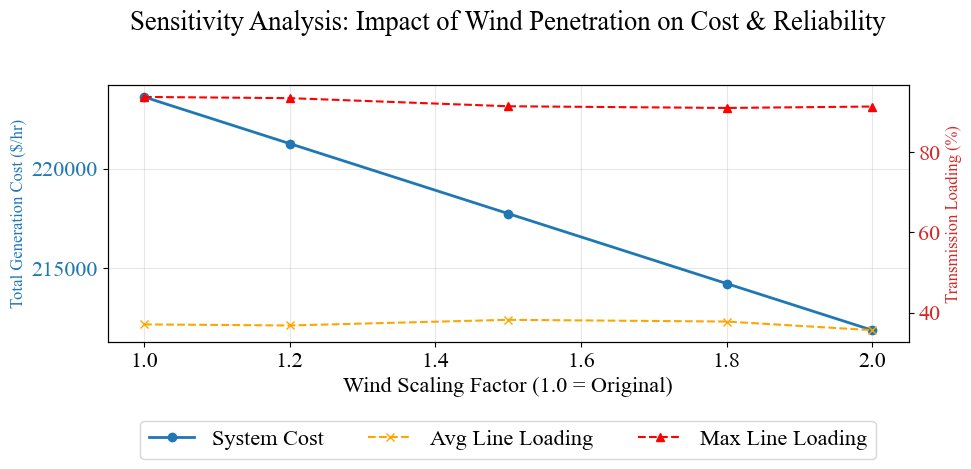

In [40]:


# ==========================================
# 1. SETUP & NETWORK MODIFICATION
# ==========================================
wind_factors = [1.0, 1.2, 1.5, 1.8, 2.0]
# wind_factors = [1.5, 1.8, 2.0, 2.5]
sensitivity_data = {
    'factor': [],
    'cost': [],
    'avg_loading': [],
    'max_loading': []
}


# ==========================================
#  WIND SENSITIVITY LOOP
# ==========================================
for factor in wind_factors:
    print(f"\n--- Processing Factor {factor}x ---")
    
    # Load and Modify Generation
    plan_gen = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/combined_generation_modified.csv')
    plan_gen.loc[plan_gen['FUEL_TYPE'] == 'WND', 'PMAX'] *= factor
    
    # Save Modified Generation
    gens_file_modified_wind =BASE_DIR / f'data/inputs/Planned_Case/combined_generation_modified_wind_{factor}.csv'
    plan_gen.to_csv(gens_file_modified_wind, index=False)
    
    # Reload for processing
    # CRITICAL FIX: Use a different variable name for the DataFrame
    gens_modified_df = pd.read_csv(gens_file_modified_wind)
    
    # Calculate Slack Bus
    gen_per_bus = gens_modified_df.groupby('ZONE')['PMAX'].sum()
    slack_bus_zone = gen_per_bus.idxmax()
    

    
    # Build Generator Data
    # CRITICAL FIX: Initialize a separate list for the matrix
    gens_matrix_list = []
    
    # Filter for valid zones first
    gens_modified_df['ZONE'] = gens_modified_df['ZONE'].str.strip()
    gens_valid = gens_modified_df[gens_modified_df['ZONE'].isin(zones)]
    
    for _, row in gens_valid.iterrows():
        bus_num = int(bus_map[row['ZONE']])
        PG = float(row['PG'])
        QG = 0.0
        QMAX = float(row['QMAX']) if 'QMAX' in row else 0.0
        QMIN = float(row['QMIN']) if 'QMIN' in row else 0.0
        VG, MBASE, GEN_STATUS = 1.0, 100.0, 1
        PMAX = float(row['PMAX'])
        PMIN = float(row['PMIN'])
        
        # Append to the LIST, not the DataFrame
        gens_matrix_list.append([bus_num, PG, QG, QMAX, QMIN, VG, MBASE, GEN_STATUS, PMAX, PMIN, 0, 0, 0, 0])

    # Convert list to numpy array
    gens_matrix_array = np.array(gens_matrix_list, dtype=float)

    # Build PPC
    ppc_modified = {
        'version': '2',
        'baseMVA': 100,
        'bus': bus_data,
        'gen': gens_matrix_array,
        'branch': branch_data,
        'gencost': np.array(gencost_data),
    }
    
    # Run OPF
    results_temp = runopf(ppc_modified, ppopt)
    
    if results_temp['success']:
        cost = results_temp['f']
        flows = np.abs(results_temp['branch'][:, 13])
        limits = results_temp['branch'][:, 5]
        valid_lines = limits > 0
        utilization = (flows[valid_lines] / limits[valid_lines]) * 100
        total_capacity = np.sum(results_temp['gen'][:,8])  
        df = pd.DataFrame({
            "branch_idx": network["branch_idx"],
            "line": valid_lines,
            "flow": flows,
            "limit": limits,
            "utilization": utilization,
            "cost":cost,
            "capacity" : total_capacity

        })
        filename = BASE_DIR / f"results/line_loads_factor_wind_{factor}.csv"

        df.to_csv(filename, index=False)
        sensitivity_data['factor'].append(factor)
        sensitivity_data['cost'].append(cost)
        sensitivity_data['avg_loading'].append(np.mean(utilization))
        sensitivity_data['max_loading'].append(np.max(utilization))
        print(f"  OPF: Converged. Cost=${cost:,.0f}")
    else:
        print(f"  OPF: Failed to converge.")

# ==========================================
# 3. PRINT & PLOT
# ==========================================
print('\n========================= Sensitivity Data =========================')
results_df = pd.DataFrame(sensitivity_data)
pd.options.display.float_format = '{:,.2f}'.format
print(results_df)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Wind Scaling Factor (1.0 = Original)')
ax1.set_ylabel('Total Generation Cost ($/hr)', color=color, fontsize=12)
ax1.plot(sensitivity_data['factor'], sensitivity_data['cost'], marker='o', color=color, linewidth=2, label='System Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Transmission Loading (%)', color=color, fontsize=12)
ax2.plot(sensitivity_data['factor'], sensitivity_data['avg_loading'], marker='x', linestyle='--', color='orange', label='Avg Line Loading')
ax2.plot(sensitivity_data['factor'], sensitivity_data['max_loading'], marker='^', linestyle='--', color='red', label='Max Line Loading')
ax2.tick_params(axis='y', labelcolor=color)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)

plt.title('Sensitivity Analysis: Impact of Wind Penetration on Cost & Reliability', pad=40)
plt.tight_layout()
plt.show()

# Sensitivity Analysis of Offshore


--- Processing Factor 1.0x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$223,592

--- Processing Factor 1.2x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$223,517

--- Processing Factor 1.5x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$223,405

--- Processing Factor 1.8x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$223,293

--- Processing Factor 2.0x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$223,218

=========

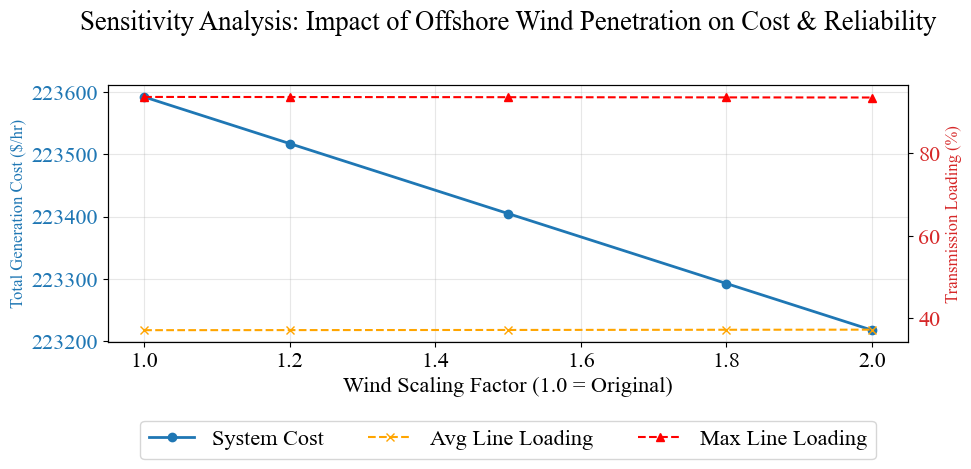

In [41]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# ==========================================
# 1. SETUP & NETWORK MODIFICATION
# ==========================================
wind_factors = [1.0, 1.2, 1.5, 1.8, 2.0]
# wind_factors = [1.5, 1.8, 2.0, 2.5]
sensitivity_data = {
    'factor': [],
    'cost': [],
    'avg_loading': [],
    'max_loading': []
}

# Build Branch Data Matrix
branch_data = []
branch_index = []
for _, row in network.iterrows():
    fbus = bus_map[row['Start_Zone'].strip()]
    tbus = bus_map[row['End_Zone'].strip()]
    r, x, b = 0.1, 0.1, 0.0
    rateA = row['Line_Max_Flow_MW']
    branch_data.append([fbus, tbus, r, x, b, rateA, rateA, rateA, 0, 0, 1])
    branch_index.append(i)
branch_data = np.array(branch_data)
# ==========================================
#  WIND SENSITIVITY LOOP
# ==========================================
for factor in wind_factors:
    print(f"\n--- Processing Factor {factor}x ---")
    
    # Load and Modify Generation
    plan_gen = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/combined_generation_modified.csv')
    target_zones = ["PJM_Dom", "PJM_EMAC"]   

    plan_gen.loc[
        (plan_gen['FUEL_TYPE'] == 'WND') & 
        (plan_gen['ZONE'].isin(target_zones)), 
        'PMAX'
    ] *= factor
    
    # Save Modified Generation
    gens_file_modified_wind =BASE_DIR / f'data/inputs/Planned_Case/combined_generation_modified_{factor}_offshore.csv'
    plan_gen.to_csv(gens_file_modified_wind, index=False)
    
    # Reload for processing
    # CRITICAL FIX: Use a different variable name for the DataFrame
    gens_modified_df = pd.read_csv(gens_file_modified_wind)
    
    # Calculate Slack Bus
    gen_per_bus = gens_modified_df.groupby('ZONE')['PMAX'].sum()
    slack_bus_zone = gen_per_bus.idxmax()
    

    
    # Build Generator Data
    # CRITICAL FIX: Initialize a separate list for the matrix
    gens_matrix_list = []
    
    # Filter for valid zones first
    gens_modified_df['ZONE'] = gens_modified_df['ZONE'].str.strip()
    gens_valid = gens_modified_df[gens_modified_df['ZONE'].isin(zones)]
    
    for _, row in gens_valid.iterrows():
        bus_num = int(bus_map[row['ZONE']])
        PG = float(row['PG'])
        QG = 0.0
        QMAX = float(row['QMAX']) if 'QMAX' in row else 0.0
        QMIN = float(row['QMIN']) if 'QMIN' in row else 0.0
        VG, MBASE, GEN_STATUS = 1.0, 100.0, 1
        PMAX = float(row['PMAX'])
        PMIN = float(row['PMIN'])
        
        # Append to the LIST, not the DataFrame
        gens_matrix_list.append([bus_num, PG, QG, QMAX, QMIN, VG, MBASE, GEN_STATUS, PMAX, PMIN, 0, 0, 0, 0])

    # Convert list to numpy array
    gens_matrix_array = np.array(gens_matrix_list, dtype=float)

    # Build PPC
    ppc_modified = {
        'version': '2',
        'baseMVA': 100,
        'bus': bus_data,
        'gen': gens_matrix_array,
        'branch': branch_data,
        'gencost': np.array(gencost_data),
    }
    
    # Run OPF
    results_temp = runopf(ppc_modified, ppopt)
    
    if results_temp['success']:
        cost = results_temp['f']
        flows = np.abs(results_temp['branch'][:, 13])
        limits = results_temp['branch'][:, 5]
        valid_lines = limits > 0
        utilization = (flows[valid_lines] / limits[valid_lines]) * 100
        total_capacity = np.sum(results_temp['gen'][:,8]) 
        df = pd.DataFrame({
            "branch_idx": network["branch_idx"],
            "line": valid_lines,
            "flow": flows,
            "limit": limits,
            "utilization": utilization,
            "cost":cost,
            "capacity" : total_capacity
        })
        filename = BASE_DIR / f"results/line_loads_factor_{factor}_offshore.csv"

        df.to_csv(filename, index=False)
        sensitivity_data['factor'].append(factor)
        sensitivity_data['cost'].append(cost)
        sensitivity_data['avg_loading'].append(np.mean(utilization))
        sensitivity_data['max_loading'].append(np.max(utilization))
        print(f"  OPF: Converged. Cost=${cost:,.0f}")
    else:
        print(f"  OPF: Failed to converge.")

# ==========================================
# 3. PRINT & PLOT
# ==========================================
print('\n========================= Sensitivity Data =========================')
results_df = pd.DataFrame(sensitivity_data)
pd.options.display.float_format = '{:,.2f}'.format
print(results_df)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Wind Scaling Factor (1.0 = Original)')
ax1.set_ylabel('Total Generation Cost ($/hr)', color=color, fontsize=12)
ax1.plot(sensitivity_data['factor'], sensitivity_data['cost'], marker='o', color=color, linewidth=2, label='System Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Transmission Loading (%)', color=color, fontsize=12)
ax2.plot(sensitivity_data['factor'], sensitivity_data['avg_loading'], marker='x', linestyle='--', color='orange', label='Avg Line Loading')
ax2.plot(sensitivity_data['factor'], sensitivity_data['max_loading'], marker='^', linestyle='--', color='red', label='Max Line Loading')
ax2.tick_params(axis='y', labelcolor=color)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)

plt.title('Sensitivity Analysis: Impact of Offshore Wind Penetration on Cost & Reliability', pad=40)
plt.tight_layout()
plt.show()

In [42]:
# 1. Check generator cost columns and a few rows
print(gens_modified_df.columns)   # see what cost columns you have (C2,C1,C0 or similar)
print(gens_modified_df.head(10))

# 2. Show summary stats to see magnitudes
print(gens_modified_df[['PMAX','PMIN']].describe())
# If you have explicit cost columns:
for col in ['C2','C1','C0','MCOST','MARGINAL_COST']:
    if col in gens_modified_df.columns:
        print(col, gens_modified_df[col].describe())


Index(['ZONE', 'FUEL_TYPE', 'PMAX', 'COST', 'FUEL_COST_NAME', 'GEN_ID',
       'PLANT_NAME', 'BUS', 'PG', 'PMIN'],
      dtype='object')
                                             ZONE FUEL_TYPE     PMAX  COST  \
0  0    ERC_PHDL\nName: IPM_Region, dtype: object       SUN     4.50  0.00   
1  0    ERC_PHDL\nName: IPM_Region, dtype: object       WAT    65.50  0.00   
2  0    ERC_PHDL\nName: IPM_Region, dtype: object       WND     3.60  0.00   
3                                          MIS_AR       SUN   237.20  0.00   
4                                          MIS_IA       SUN    10.60  0.00   
5                                          MIS_IL       BIT 2,433.60  2.14   
6                                          MIS_IL       DFO   298.90 21.50   
7                                          MIS_IL       LFG     6.40  1.50   
8                                          MIS_IL       MWH   196.30  0.00   
9                                          MIS_IL        NG 6,447.60  2.55   

    

# Sensitivity Analysis of Solar


--- Processing Factor 1.0x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$223,592

--- Processing Factor 1.2x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$201,993

--- Processing Factor 1.5x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$169,594

--- Processing Factor 1.8x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$138,232

--- Processing Factor 2.0x ---
PYPOWER Version 5.1.18, 10-Apr-2025 -- DC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!
  OPF: Converged. Cost=$118,747

=========

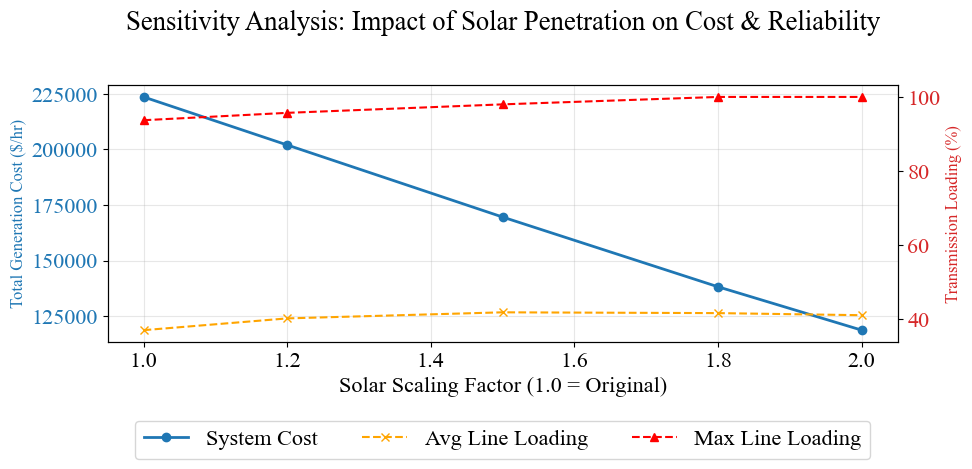

In [44]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# ==========================================
# 1. SETUP & NETWORK MODIFICATION
# ==========================================
solar_factors = [1.0, 1.2, 1.5, 1.8, 2.0]
sensitivity_data = {
    'factor': [],
    'cost': [],
    'avg_loading': [],
    'max_loading': []
}


network_s_solar = pd.read_csv(network_file_modified)

# Build Branch Data Matrix
branch_data = []
branch_index = []
for _, row in network_s_solar.iterrows():
    fbus = bus_map[row['Start_Zone'].strip()]
    tbus = bus_map[row['End_Zone'].strip()]
    r, x, b = 0.1, 0.1, 0.0
    rateA = row['Line_Max_Flow_MW']
    branch_data.append([fbus, tbus, r, x, b, rateA, rateA, rateA, 0, 0, 1])
    branch_index.append(i)
branch_data = np.array(branch_data)

# ==========================================
# 2. SOLAR SENSITIVITY LOOP
# ==========================================
for factor in solar_factors:
    print(f"\n--- Processing Factor {factor}x ---")
    
    # Load and Modify Generation
    plan_gen = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/combined_generation_modified.csv')
    plan_gen.loc[plan_gen['FUEL_TYPE'] == 'SUN', 'PMAX'] *= 1*factor
    
    # Save Modified Generation
    gens_file_modified_solar =BASE_DIR /  f'data/inputs/Planned_Case/combined_generation_modified_solar_{factor}.csv'
    plan_gen.to_csv(gens_file_modified_solar, index=False)
    
    # Reload for processing
    # CRITICAL FIX: Use a different variable name for the DataFrame
    gens_modified_df = pd.read_csv(gens_file_modified_solar)

    
    # Calculate Slack Bus
    gen_per_bus = gens_modified_df.groupby('ZONE')['PMAX'].sum()
    slack_bus_zone = gen_per_bus.idxmax()
    
    
    # Build Generator Data
    # CRITICAL FIX: Initialize a separate list for the matrix
    gens_matrix_list = []
    
    # Filter for valid zones first
    gens_modified_df['ZONE'] = gens_modified_df['ZONE'].str.strip()
    gens_valid = gens_modified_df[gens_modified_df['ZONE'].isin(zones)]
    
    for _, row in gens_valid.iterrows():
        bus_num = int(bus_map[row['ZONE']])
        PG = float(row['PG'])
        QG = 0.0
        QMAX = float(row['QMAX']) if 'QMAX' in row else 0.0
        QMIN = float(row['QMIN']) if 'QMIN' in row else 0.0
        VG, MBASE, GEN_STATUS = 1.0, 100.0, 1
        PMAX = float(row['PMAX'])
        PMIN = float(row['PMIN'])
        
        # Append to the LIST, not the DataFrame
        gens_matrix_list.append([bus_num, PG, QG, QMAX, QMIN, VG, MBASE, GEN_STATUS, PMAX, PMIN, 0, 0, 0, 0])

    # Convert list to numpy array
    gens_matrix_array = np.array(gens_matrix_list, dtype=float)

    # Build PPC
    ppc_modified = {
        'version': '2',
        'baseMVA': 100,
        'bus': bus_data,
        'gen': gens_matrix_array,
        'branch': branch_data,
        'gencost': np.array(gencost_data),
    }
    
    # Run OPF
    results_temp = runopf(ppc_modified, ppopt)
    
    if results_temp['success']:
        cost = results_temp['f']
        flows = np.abs(results_temp['branch'][:, 13])
        limits = results_temp['branch'][:, 5]
        valid_lines = limits > 0
        utilization = (flows[valid_lines] / limits[valid_lines]) * 100
        total_capacity = np.sum(results_temp['gen'][:,8]) 
        df = pd.DataFrame({
            "branch_idx": network["branch_idx"],
            "line": valid_lines,
            "flow": flows,
            "limit": limits,
            "utilization": utilization,
            "cost":cost,
            "capacity" : total_capacity
        })
        filename = BASE_DIR / f"results/line_loads_factor_{factor}_solar.csv"

        df.to_csv(filename, index=False)
        sensitivity_data['factor'].append(factor)
        sensitivity_data['cost'].append(cost)
        sensitivity_data['avg_loading'].append(np.mean(utilization))
        sensitivity_data['max_loading'].append(np.max(utilization))
        print(f"  OPF: Converged. Cost=${cost:,.0f}")
    else:
        print(f"  OPF: Failed to converge.")

# ==========================================
# 3. PRINT & PLOT
# ==========================================
print('\n========================= Sensitivity Data =========================')
results_df = pd.DataFrame(sensitivity_data)
pd.options.display.float_format = '{:,.2f}'.format
print(results_df)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Solar Scaling Factor (1.0 = Original)')
ax1.set_ylabel('Total Generation Cost ($/hr)', color=color, fontsize=12)
ax1.plot(sensitivity_data['factor'], sensitivity_data['cost'], marker='o', color=color, linewidth=2, label='System Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Transmission Loading (%)', color=color, fontsize=12)
ax2.plot(sensitivity_data['factor'], sensitivity_data['avg_loading'], marker='x', linestyle='--', color='orange', label='Avg Line Loading')
ax2.plot(sensitivity_data['factor'], sensitivity_data['max_loading'], marker='^', linestyle='--', color='red', label='Max Line Loading')
ax2.tick_params(axis='y', labelcolor=color)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)

plt.title('Sensitivity Analysis: Impact of Solar Penetration on Cost & Reliability', pad=40)
plt.tight_layout()
plt.show()

# End of code